# GA model calibration

This notebook applies a genetic algorithm (GA) to calibrate wall decay coefficients using data from each water quality sensing period.

In [14]:
import pandas as pd
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.colors
default_colors = plotly.colors.qualitative.Plotly
from bayesian_wq_calibration.epanet import build_model, epanet_simulator, sensor_model_id
from bayesian_wq_calibration.calibration import evaluate, decision_variables_to_dict
from bayesian_wq_calibration.constants import TIMESERIES_DIR, RESULTS_DIR
from bayesian_wq_calibration.plotting import plot_network, plot_network_animation
from bayesian_wq_calibration.data import bulk_temp_adjust
import random
from deap import base, creator, tools, algorithms
from functools import partial
import multiprocessing
import time

### Load data and build water model

Load operational data for selected sensing period.

In [15]:
data_period = 20 # 20 calibration events (as at 30 October 2024)
ga_run = True
save_results = True
wq_sensors_used = 'kiosk only' # 'kiosk only', 'kiosk + hydrant'

try:
    flow_df = pd.read_csv(TIMESERIES_DIR / f"processed/{str(data_period).zfill(2)}-flow.csv")
    pressure_df = pd.read_csv(TIMESERIES_DIR / f"processed/{str(data_period).zfill(2)}-pressure.csv")
    wq_df = pd.read_csv(TIMESERIES_DIR / f"processed/{str(data_period).zfill(2)}-wq.csv", low_memory=False)
    cl_df = wq_df[wq_df['data_type'] == 'chlorine']
    
    if wq_sensors_used == 'kiosk only':
        kiosk_ids = ['BW1', 'BW2', 'BW4', 'BW5', 'BW9', 'BW12']
        cl_df = cl_df[cl_df['bwfl_id'].isin(kiosk_ids)]
    
    print(f"Calibrating wall model decay coefficients for data period: {data_period}...")
    
except:
    print(f"Data period {data_period} does not exist.")

Calibrating wall model decay coefficients for data period: 20...


Split sensing data into train and test datasets.

In [16]:
n_total = len(flow_df['datetime'].unique())
n_train = 3 * 24 * 4 # 2 training days (day 1 discarded in wq simulation)

train_range = range(n_train)
train_datetime = flow_df['datetime'].unique()[list(train_range)]

test_range = range(n_train, n_total)
test_datetime = flow_df['datetime'].unique()[list(test_range)]

total_range = range(n_total)
total_datetime = flow_df['datetime'].unique()[list(total_range)]

Build water model via WNTR module.

In [17]:
demand_resolution = 'wwmd'
bulk_coeff = -0.85 # day^-1 (from bottle tests)
field_temp = wq_df[wq_df['data_type'] == 'temperature']['mean'].mean()
bulk_coeff = bulk_temp_adjust(bulk_coeff, field_temp)

wn_train = build_model(flow_df[flow_df['datetime'].isin(train_datetime)], pressure_df[pressure_df['datetime'].isin(train_datetime)], cl_df[cl_df['datetime'].isin(train_datetime)], sim_type='chlorine', demand_resolution=demand_resolution, bulk_coeff=bulk_coeff)

Set grouping type and initialize decay coefficients.

In [18]:
# see notebook `02-pipe-grouping-exploration.ipynb` for details on pipe groups
grouping = 'material-age-velocity'

if grouping == 'single':
    param_bounds = [(-0.5, 0.0)] # single wall decay coefficient
elif grouping == 'material-only':
    param_bounds = [(-0.5, 0.0), (-0.5, 0.0), (-0.05, 0.0)] # variable order: M0, M1, M2
elif grouping == 'material-age-diameter':
    param_bounds = [(-0.5, 0.0), (-0.5, 0.0), (-0.2, 0.0), (-0.2, 0.0), (-0.1, 0.0), (-0.1, 0.0)] # variable order: G0, G1, G2, G3, G4, G5
elif grouping == 'material-age-velocity':
    param_bounds = [(-0.5, 0.0), (-0.5, 0.0), (-0.2, 0.0), (-0.2, 0.0), (-0.1, 0.0), (-0.1, 0.0)] # variable order: G0, G1, G2, G3, G4, G5
    
n_params = len(param_bounds)

In [19]:
def enforce_bounds(individual, param_bounds):
    for i, (lb, ub) in enumerate(param_bounds):
        if individual[i] < lb:
            individual[i] = lb
        elif individual[i] > ub:
            individual[i] = ub
    return individual

### Initialize GA using DEAP module.

Assign default parameters.

In [20]:
popsize = 50
ngen = 50
cxpb = 0.7
mutpb = 0.1
tournsize = 3
hofsize = 1

Set up DEAP structures.

In [21]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # minimize objective function
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()
def generate_individual():
    return [random.uniform(lb, ub) for lb, ub in param_bounds]
toolbox.register("individual", tools.initIterate, creator.Individual, generate_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
# toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("select", tools.selTournament, tournsize=tournsize)
# pool = multiprocessing.Pool()
# toolbox.register("map", pool.map)

low = [b[0] for b in param_bounds]
up = [b[1] for b in param_bounds]
toolbox.register("mutate", tools.mutPolynomialBounded, low=low, up=up, eta=20, indpb=0.2)

### Run GA

In [22]:
def main(wn, cl_df, grouping):
    
    start_time = time.time()
    
    # preload data into the evaluation function
    evaluation_function = partial(evaluate, wn=wn, cl_df=cl_df, grouping=grouping)
    toolbox.register("evaluate", evaluation_function)

    # define statistics
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", np.max)
    stats.register("mean", np.mean)
    stats.register("min", np.min)

    # initialize GA parameters
    pop = toolbox.population(n=popsize)
    hof = tools.HallOfFame(hofsize)
    logbook = tools.Logbook()

    # set early stopping criteria
    stagnant_gens = 0
    max_stagnant_gens = 5
    threshold = 1e-4 

    # run GA
    for g in range(ngen):
        
        if g != 0:
            pop = toolbox.select(pop, k=len(pop))
            pop = algorithms.varAnd(pop, toolbox, cxpb=cxpb, mutpb=mutpb)
            
            for ind in pop:
                enforce_bounds(ind, param_bounds)
        
        # evaluate the individuals with invalid fitness
        invalids = [ind for ind in pop if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalids)
        for ind, fit in zip(invalids, fitnesses):
            ind.fitness.values = fit

        # update hall of fame and compile statistics
        hof.update(pop)
        record = stats.compile(pop)
        logbook.record(gen=g, nevals=len(invalids), **record)
        # if g == 0:
        #     print(logbook.stream)
        # else:
        #     print(logbook.stream.splitlines()[-1])

        # retrieve current best fitness from hall of fame
        current_best_fitness = hof[0].fitness.values[0]
        
        # initialize previous_best_fitness at the end of the first generation's evaluation
        if g == 0:
            previous_best_fitness = current_best_fitness

        # calculate percent difference for early stopping
        percent_difference = abs(current_best_fitness - previous_best_fitness) / max(abs(previous_best_fitness), 1e-6)
        print(f"Gen {g}: Current best fitness = {current_best_fitness}, Previous best fitness = {previous_best_fitness}, Percent difference = {percent_difference}, Stagnant generation = {stagnant_gens}.")

        # check if improvement exceeds threshold
        if percent_difference > threshold:
            previous_best_fitness = current_best_fitness
            stagnant_gens = 0
        else:
            stagnant_gens += 1
    
        # early stopping if no improvement
        if stagnant_gens >= max_stagnant_gens:
            print(f"Terminating GA @ generation {g} due to solution quality stagnation. Best fitness: {current_best_fitness}")
            break
        
    cpu_time = time.time() - start_time 
    
    return pop, logbook, hof, cpu_time


In [23]:
if ga_run:
    pop, log, hof, cpu_time = main(wn_train, cl_df[cl_df['datetime'].isin(train_datetime)], grouping)

Gen 0: Current best fitness = 0.0014661908849282787, Previous best fitness = 0.0014661908849282787, Percent difference = 0.0, Stagnant generation = 0.
Gen 1: Current best fitness = 0.0014661908849282787, Previous best fitness = 0.0014661908849282787, Percent difference = 0.0, Stagnant generation = 1.
Gen 2: Current best fitness = 0.0014661908849282787, Previous best fitness = 0.0014661908849282787, Percent difference = 0.0, Stagnant generation = 2.
Gen 3: Current best fitness = 0.0012123032883052732, Previous best fitness = 0.0014661908849282787, Percent difference = 0.17316135247657394, Stagnant generation = 3.
Gen 4: Current best fitness = 0.0011888885121123388, Previous best fitness = 0.0012123032883052732, Percent difference = 0.01931428910472299, Stagnant generation = 0.
Gen 5: Current best fitness = 0.0011888885121123388, Previous best fitness = 0.0011888885121123388, Percent difference = 0.0, Stagnant generation = 0.
Gen 6: Current best fitness = 0.0011888885121123388, Previous 

Get train and test MSE results.

In [24]:
# get optimized decay coefficients
if ga_run:
    wall_coeffs_opt = decision_variables_to_dict(grouping, hof[0])
    print(wall_coeffs_opt)
else:
    results_df = pd.read_excel(RESULTS_DIR / 'wq/ga_calibration.xlsx', sheet_name=grouping)
    selected_row = results_df[results_df['data_period'] == data_period]
    wall_coeff_columns = [col for col in results_df.columns if col.startswith('G')]
    wall_coeffs_opt_vector = selected_row[wall_coeff_columns].values.flatten()
    wall_coeffs_opt = decision_variables_to_dict(grouping, wall_coeffs_opt_vector)
    print(wall_coeffs_opt)

# model simulation
wn = build_model(flow_df, pressure_df, cl_df, sim_type='chlorine', demand_resolution='wwmd', grouping=grouping, wall_coeffs=wall_coeffs_opt)
sim_results = epanet_simulator(wn, 'chlorine', cl_df)
cl_sim = sim_results.chlorine

# obtain simulated data @ sensor nodes
sensor_data = sensor_model_id('wq')
cl_sim_sensor = cl_sim[sensor_data['model_id'].unique()]
name_mapping = sensor_data.set_index('model_id')['bwfl_id'].to_dict()
cl_sim_sensor = cl_sim_sensor.rename(columns=name_mapping)
cl_df_bwfl_ids = cl_df['bwfl_id'].unique()
bwfl_ids = [sensor for sensor in sensor_data['bwfl_id'].unique() if sensor in cl_df_bwfl_ids and sensor not in ['BW1', 'BW4']]
datetime = cl_df['datetime'].unique()

# compute train mse
train_mse = 0
test_mse = 0
for name in bwfl_ids:
    sim = cl_sim_sensor[name].values
    data = cl_df.loc[cl_df['bwfl_id'] == name, 'mean'].values
    train_mask = ~np.isnan(sim) & ~np.isnan(data) & (np.arange(len(sim)) >= 96) & (np.arange(len(sim)) < n_train)
    train_mse += (1 / (len(datetime[96:n_train]) * len(bwfl_ids))) * np.sum((sim[train_mask] - data[train_mask]) ** 2)
    test_mask = ~np.isnan(sim) & ~np.isnan(data) & (np.arange(len(sim)) >= n_train)
    test_mse += (1 / (len(datetime[n_train:]) * len(bwfl_ids))) * np.sum((sim[test_mask] - data[test_mask]) ** 2)

print(f"Train MSE: {train_mse}")
# assert train_mse == hof[0].fitness.values[0], "GA train mse is not the same as a posteriori computation."
print(f"Test MSE: {test_mse}")

{'G0': -0.4139459556681843, 'G1': -0.11212509834885281, 'G2': -0.09758702616299095, 'G3': -1.5129534834822774e-05, 'G4': -0.03370935915150545, 'G5': -0.09999755134082058}
Train MSE: 0.0011188661634686772
Test MSE: 0.001250219107636872


Save GA results to master spreadsheet.

In [25]:
if save_results:
    results_df = pd.read_excel(RESULTS_DIR / 'wq/ga_calibration.xlsx', sheet_name=grouping)

    new_row = {
        'data_period': data_period,
        'train_mse': train_mse,
        'test_mse': test_mse,
        'cpu_time': cpu_time,
        'demand_resolution': demand_resolution,
        'bulk_coeff': wn_train.options.reaction.bulk_coeff * 3600 * 24,
        'wq_sensors_used': wq_sensors_used,
    }
    for key, val in wall_coeffs_opt.items():
        new_row[key] = val
        
    new_row_df = pd.DataFrame([new_row])
    results_df = pd.concat([results_df, new_row_df], ignore_index=True)

    with pd.ExcelWriter(RESULTS_DIR / 'wq/ga_calibration.xlsx', mode='a', if_sheet_exists='replace') as writer:
        results_df.to_excel(writer, sheet_name=grouping, index=False)

### Plot results

Time series plots.

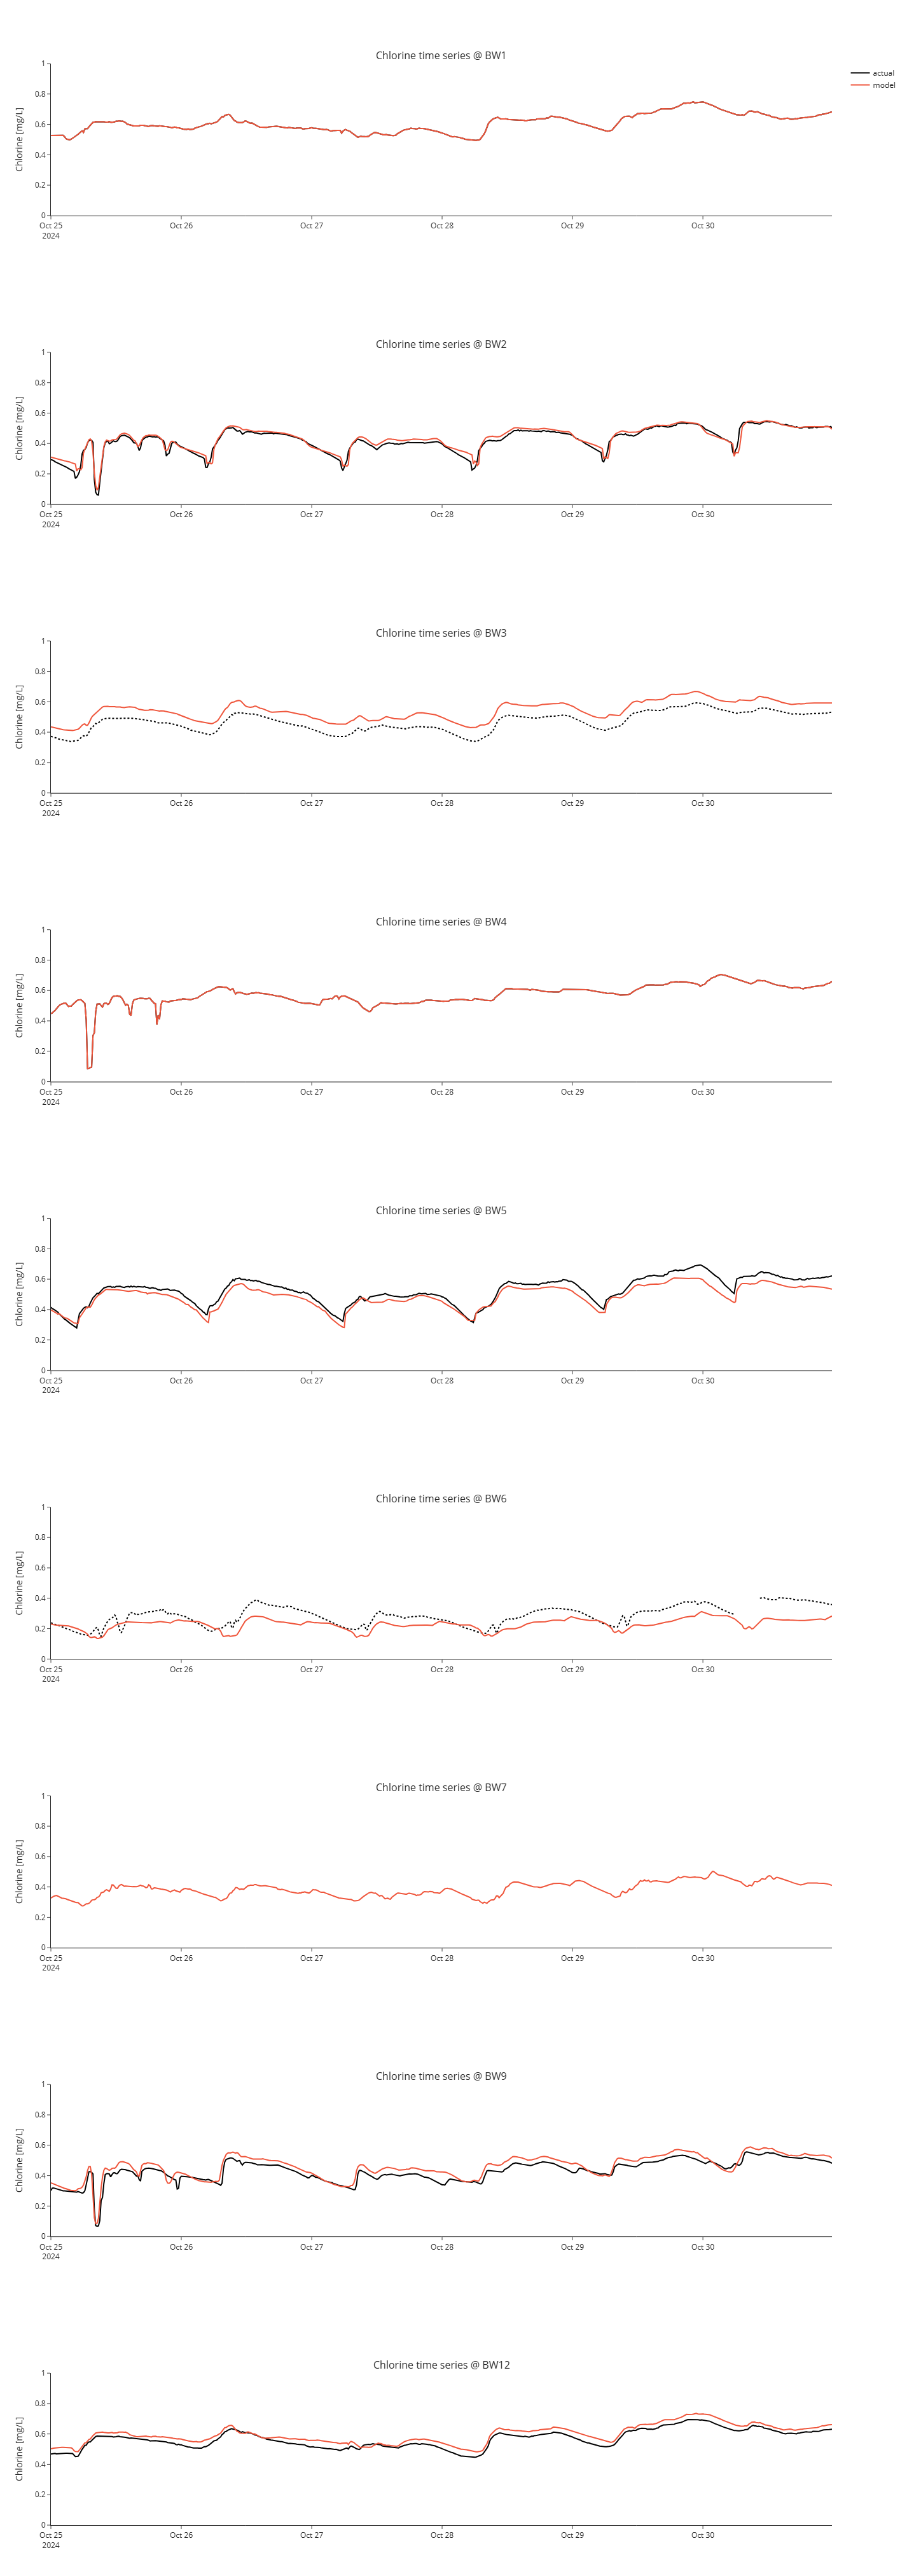

In [26]:
# bwfl_ids = [bwfl_id for bwfl_id in wq_df['bwfl_id'].unique() if bwfl_id not in ['BW1', 'BW4']]
bwfl_ids = ['BW1', 'BW2', 'BW3', 'BW4', 'BW5', 'BW6', 'BW7', 'BW9', 'BW12']
subplot_titles = [f"Chlorine time series @ {bwfl_id}" for bwfl_id in bwfl_ids]
fig = make_subplots(rows=len(bwfl_ids), cols=1, subplot_titles=subplot_titles)

y_max = 1.0

for idx, bwfl_id in enumerate(bwfl_ids): 
    data = wq_df[(wq_df['bwfl_id'] == bwfl_id) & (wq_df['data_type'] == 'chlorine')]
    sim = cl_sim_sensor[bwfl_id].values
    show_legend = (idx == 0)

    # sensor data
    if wq_sensors_used == 'kiosk only':
        if bwfl_id in ['BW3', 'BW6', 'BW7']:
            dash = 'dot'
        else:
            dash = 'solid'
            
    fig.add_trace(
        go.Scatter(
            x=data['datetime'][96:],
            y=data['mean'][96:],
            mode='lines',
            name='actual',
            line=dict(color='black', dash=dash),
            showlegend=show_legend
        ),
        row=idx + 1, col=1
    )
    
    # simulated data
    fig.add_trace(
        go.Scatter(
            x=data['datetime'][96:],
            y=sim[96:],
            mode='lines',
            name='model',
            line=dict(color=default_colors[1]),
            showlegend=show_legend
        ),
        row=idx + 1, col=1
    )
    fig.update_yaxes(title_text="Chlorine [mg/L]", rangemode="tozero", range=[0, y_max], row=idx + 1, col=1)

fig.update_layout(
    height=450 * len(bwfl_ids),
    template='simple_white',
    legend_title_text='',
)

fig.show()

Residual boxplots.

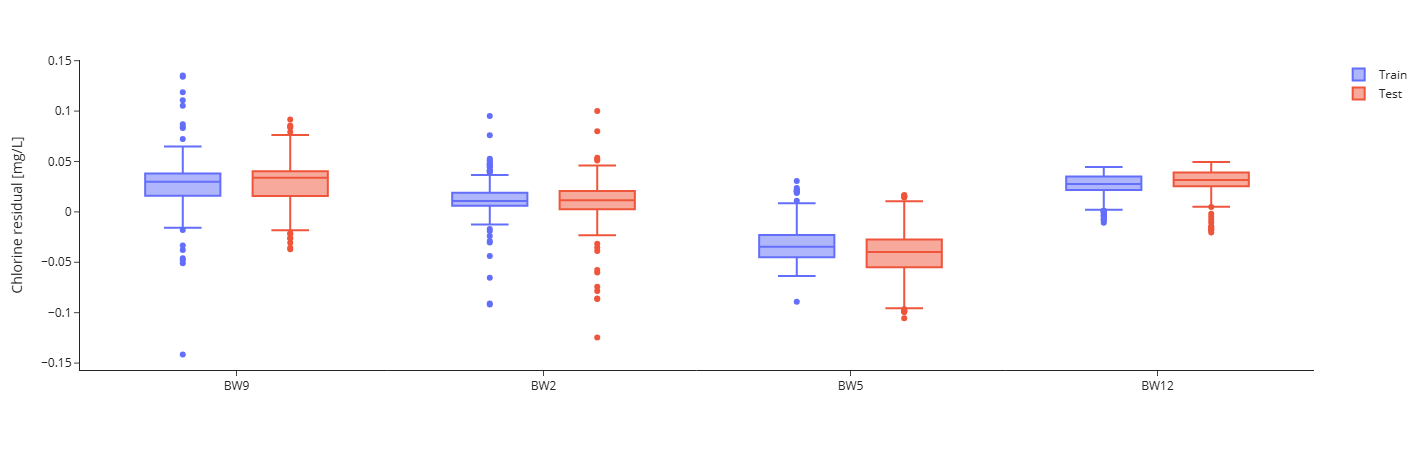

In [28]:
bwfl_ids = [bwfl_id for bwfl_id in cl_df['bwfl_id'].unique() if bwfl_id not in ['BW1', 'BW4']]

residuals_df = pd.DataFrame(columns=['bwfl_id', 'Residuals', 'Dataset'])
for bwfl_id in bwfl_ids:
    data = cl_df[cl_df['bwfl_id'] == bwfl_id]
    sim = cl_sim_sensor[bwfl_id].values
    train_residuals = sim[96:n_train] - data['mean'].values[96:n_train]
    test_residuals = sim[n_train:] - data['mean'].values[n_train:]
    
    residuals_df = pd.concat([
        residuals_df,
        pd.DataFrame({'bwfl_id': bwfl_id, 'Residuals': train_residuals, 'Dataset': 'Train'}),
        pd.DataFrame({'bwfl_id': bwfl_id, 'Residuals': test_residuals, 'Dataset': 'Test'})
    ], ignore_index=True)

fig = px.box(residuals_df, x='bwfl_id', y='Residuals', color='Dataset',
             labels={'bwfl_id': 'BWFL ID', 'Residuals': 'Residuals'},
             points='outliers')

fig.update_layout(
    height=450,
    xaxis_title='',
    yaxis_title='Chlorine residual [mg/L]',
    template='simple_white',
    legend_title_text='',
)
fig.show()

Network residuals plot.

In [ ]:
# format simulation results
column_names_cl = [f'cl_{t+1}' for t in range(cl_sim.shape[0])]
cl_sim_T = cl_sim.T
cl_sim_T.columns = column_names_cl
cl_sim_T = cl_sim_T.reset_index().rename(columns={'name': 'node_id'})

# plot network
t = 96 * 2 + (4 * 4)
plot_network(vals=cl_sim_T, val_type='chlorine', t=t)

# # play network animation
# datetime = cl_df['datetime'].unique()
# plot_network_animation(cl_sim_T, datetime)